In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from IPython.display import display
#import sweetviz as sv
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, cross_val_score,  RepeatedStratifiedKFold,RandomizedSearchCV, GridSearchCV


from sklearn.metrics import classification_report, roc_curve, confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

from sklearn.impute import KNNImputer

# modelos
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, \
VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# AED

In [48]:
t = pd.read_csv("healthcare-dataset-stroke-data.csv")
t.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [49]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df = df.drop(['id'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [50]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [51]:
## you can donwload this notebook, and instal SweetViz. Then, uncomment these lines for some cool data exploration.

#analise = sv.analyze(df)
#analise.show_html('analise.html', layout = 'vertical', scale =1.0);

In [52]:
df.head(2)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1


In [53]:
df.work_type.value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [54]:
df['bmi']

0       36.6
1        NaN
2       32.5
3       34.4
4       24.0
        ... 
5105     NaN
5106    40.0
5107    30.6
5108    25.6
5109    26.2
Name: bmi, Length: 5110, dtype: float64

<AxesSubplot:>

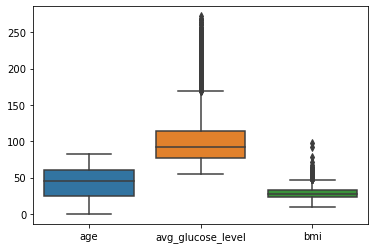

In [55]:
sns.boxplot(data = df[['age', 'avg_glucose_level','bmi']])

Etapas de pré-processamento:
- Input de missing values em 'bmi', utilizando knn imputer
- O mesmo para smoking status unknown, mantendo a coluna 'stroke'(?)
- Gender = 'other' replace 'female'
- Escalonar as colunas ['age', 'avg_glucose_level','bmi']


# Modeling

## bmi - KNNImputer

In [56]:
imputer = KNNImputer(n_neighbors = 6)
df['bmi'] = imputer.fit_transform(np.array(df['bmi']).reshape(-1,1))
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

C:\Users\CaioEstrella\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='bmi', ylabel='Density'>

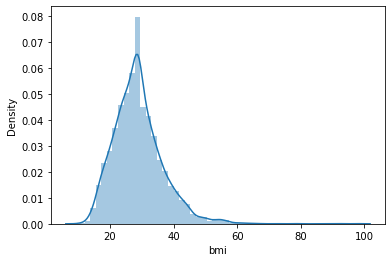

In [57]:
sns.distplot(df['bmi'])

## bmi groups

In [58]:
bmi_group = []
for bmi in df['bmi']:
    if bmi < 17.0:
        bmi_group.append(0)
    
    elif (bmi >= 17.0) & (bmi <= 18.49):
        bmi_group.append(1)
    
    elif (bmi >= 18.50) & (bmi <= 24.99):
        bmi_group.append(2)
    
    elif (bmi >= 25.0) & (bmi <= 29.99):
        bmi_group.append(3)
    
    elif (bmi >= 30.0) & (bmi <= 34.99):
        bmi_group.append(4)
    
    elif (bmi >= 35.0) & (bmi <= 39.99):
        bmi_group.append(5)
    
    elif (bmi > 39.99):
        bmi_group.append(6)
    
df['bmi_group'] = bmi_group   
df = df.drop(['bmi'], axis=1)

In [59]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'smoking_status',
       'stroke', 'bmi_group'],
      dtype='object')

## replace gender == 'other'

In [13]:
df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [14]:
df['gender'] = df['gender'].replace(to_replace='Other', value='Female')
df['gender'].value_counts()

Female    2995
Male      2115
Name: gender, dtype: int64

## Rounding Age

In [15]:
df['age'] = df['age'].apply(lambda x: round(x))
df['age']

0       67
1       61
2       80
3       49
4       79
        ..
5105    80
5106    81
5107    35
5108    51
5109    44
Name: age, Length: 5110, dtype: int64

## Scaling

<AxesSubplot:>

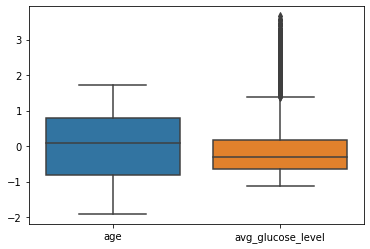

In [16]:
scaler = StandardScaler()
df_scale = pd.DataFrame(scaler.fit_transform(df[['age', 'avg_glucose_level']]))
df_scale[['age', 'avg_glucose_level']] = df_scale
df_scale = df_scale[['age', 'avg_glucose_level']]

df.drop(columns = ['age', 'avg_glucose_level'], inplace=True)
df = pd.concat([df, df_scale], axis=1)
sns.boxplot(data = df[['age', 'avg_glucose_level']])

## Correlations

In [17]:
df_temp = pd.get_dummies(df, drop_first = True)

<AxesSubplot:>

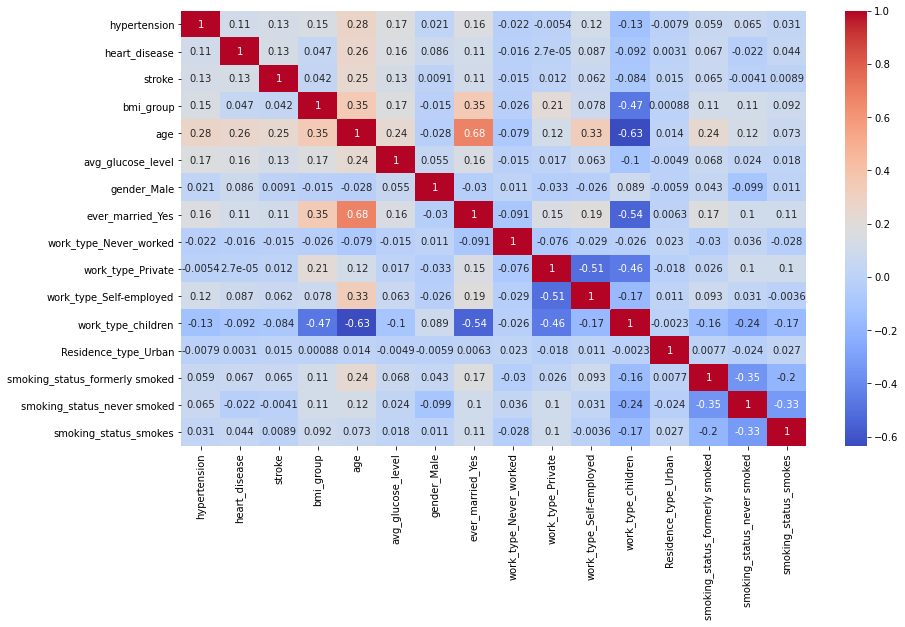

In [18]:
plt.subplots(figsize=(14,8))
sns.heatmap(df_temp.corr(), annot = True, cmap='coolwarm')

## OneHot

In [20]:
ohe = OneHotEncoder(drop = 'first', sparse=False, handle_unknown = 'error')
df_t = pd.DataFrame(ohe.fit_transform(df.select_dtypes('object')))

df_t.columns = ohe.get_feature_names()
df_t.head(2)
df_t.shape

(5110, 10)

In [21]:
df_n = df.drop(df.select_dtypes('object'), axis=1)

df = pd.concat([df_t, df_n], axis=1)
df.head(2)

,x0_Male,x1_Yes,x2_Never_worked,x2_Private,x2_Self-employed,x2_children,x3_Urban,x4_formerly smoked,x4_never smoked,x4_smokes,hypertension,heart_disease,stroke,bmi_group,age,avg_glucose_level
0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0,1,1,5,1.051430,2.706375
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,1,3,0.786067,2.121559
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,1,4,1.626384,-0.005028
3,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0,1,4,0.255341,1.437358
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0,1,2,1.582157,1.501184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1,0,0,3,1.626384,-0.494658
5106,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0,0,0,6,1.670611,0.420775
5107,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0,4,-0.363840,-0.511443
5108,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,3,0.343795,1.328257


# Testing k_neighbors for SMOTE

In [23]:
k_values = [1, 2, 3, 4, 5, 6, 7]
X = df.drop(['stroke'], axis=1)
y = df.stroke

k_scores = []
for k in k_values:
    # define pipeline
    rf = RandomForestClassifier()
    over  = SMOTE(sampling_strategy=0.1, k_neighbors=k)
    steps = [('over', over), ('model', rf)]
    
    pipeline = Pipeline(steps=steps)
    
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    scores = cross_val_score(rf, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    k_scores.append((k, score))
    print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

> k=1, Mean ROC AUC: 0.786
> k=2, Mean ROC AUC: 0.788
> k=3, Mean ROC AUC: 0.783
> k=4, Mean ROC AUC: 0.782
> k=5, Mean ROC AUC: 0.785
> k=6, Mean ROC AUC: 0.787
> k=7, Mean ROC AUC: 0.783


In [25]:
sorted(k_scores, key=lambda tup: tup[1])

[(4, 0.7816604346760633),
 (7, 0.782768772023221),
 (3, 0.7827698937815296),
 (5, 0.7852587261952043),
 (1, 0.78585591356053),
 (6, 0.7874149759311369),
 (2, 0.7884731418809483)]

In [26]:
best_k = sorted(k_scores, key=lambda tup: tup[1])[-1][0]
best_k

2

In [27]:
over  = SMOTE(k_neighbors=best_k)

steps = [('over', over)]
pipeline = Pipeline(steps=steps)
X, y = pipeline.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({1: 4861, 0: 4861})


# Models + voting classifier

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify = y, random_state=42)

In [29]:
X_train.columns

Index(['x0_Male', 'x1_Yes', 'x2_Never_worked', 'x2_Private',
       'x2_Self-employed', 'x2_children', 'x3_Urban', 'x4_formerly smoked',
       'x4_never smoked', 'x4_smokes', 'hypertension', 'heart_disease',
       'bmi_group', 'age', 'avg_glucose_level'],
      dtype='object')

## random forest

In [30]:
rf = RandomForestClassifier()

n_estimators = [100,500,700,1000]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

grid =         {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
#search_nc = GridSearchCV(estimator = pipeline, param_grid = grid, cv = 5, verbose=1, n_jobs=-1)
search = RandomizedSearchCV(estimator = rf, param_distributions = grid, cv = 5, verbose=1, n_jobs=-1)


In [31]:
search.fit(X_train, y_train)
preds = search.predict(X_test)
print(classification_report(y_test, preds))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       973
           1       0.97      0.97      0.97       972

    accuracy                           0.97      1945
   macro avg       0.97      0.97      0.97      1945
weighted avg       0.97      0.97      0.97      1945



## Gradient Boost

In [32]:
gbr = GradientBoostingClassifier()

parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01],#, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    #"min_samples_split": [1,2,3],
    "min_samples_leaf": [1,2,3],
    'max_depth' : [None, 2,3,5,10],
    #"subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[100, 300, 500, 1000],
    "warm_start" : [False, True]
    
    }
#search_gbr = RandomizedSearchCV(estimator = gbr, param_distributions = parameters, cv = 5, verbose = 2, n_jobs = -1)
search_gbr = RandomizedSearchCV(estimator = gbr,param_distributions = parameters, scoring = 'roc_auc',cv = 5, verbose = 2, n_jobs = -1)

## Extra trees


In [33]:
extra_trees = ExtraTreesClassifier()
search_extra = RandomizedSearchCV(estimator = extra_trees,param_distributions = grid, scoring = 'roc_auc',cv = 5, verbose = 2, n_jobs = -1)

## SVC

In [34]:
svc = SVC()
svc_grid = {'kernel':['linear','rbf'], 'probability' : [True]}
search_svc = RandomizedSearchCV(estimator = svc, param_distributions = svc_grid, scoring = 'roc_auc',cv = 5, verbose = 2, n_jobs = -1)

## Knn Classifier

In [35]:
knn = KNeighborsClassifier()
parameters_KNN = {
    'n_neighbors': (1,30, 1),
    'leaf_size': (20,40,1),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev')
}
search_knn = RandomizedSearchCV(estimator = knn, param_distributions = parameters_KNN, scoring = 'roc_auc',cv = 5, verbose = 2, n_jobs = -1)

## Voting Classifier

In [46]:
X_test.columns

Index(['x0_Male', 'x1_Yes', 'x2_Never_worked', 'x2_Private',
       'x2_Self-employed', 'x2_children', 'x3_Urban', 'x4_formerly smoked',
       'x4_never smoked', 'x4_smokes', 'hypertension', 'heart_disease',
       'bmi_group', 'age', 'avg_glucose_level'],
      dtype='object')

In [36]:
voting_clf = VotingClassifier( estimators = [('rfr', search ),('gbr', search_gbr),('extra', search_extra),('svc', search_svc), ('knn', knn)], voting = 'soft')
voting_clf.fit(X_train, y_train);
preds = voting_clf.predict(X_test)
print(classification_report(y_test, preds))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\CaioEstrella\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Fitting 5 folds for each of 2 candidates, totalling 10 fits
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       973
           1       0.93      0.99      0.96       972

    accuracy                           0.95      1945
   macro avg       0.96      0.95      0.95      1945
weighted avg       0.96      0.95      0.95      1945



# Moving Threshold

Melhor Threshold = 0.647155, G-Mean = 0.968


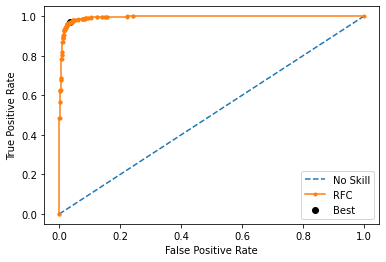

In [37]:
probas = voting_clf.predict_proba(X_test)
#Gets class 1 probas
probas = probas[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probas)

# calculates g-mean for each threshold
gmeans = (tpr * (1-fpr)) ** (1/2)
# finds the index of the highest g-mean
ix = np.argmax(gmeans)
best_threshold = thresholds[ix]
print('Melhor Threshold = %f, G-Mean = %.3f' % (thresholds[ix], gmeans[ix]))

plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='RFC')
plt.scatter(fpr[ix], tpr[ix], marker = 'o', color = 'black', label = 'Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [38]:
decisions = (probas >= best_threshold).astype(int)
print(classification_report(y_test, decisions))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       973
           1       0.97      0.97      0.97       972

    accuracy                           0.97      1945
   macro avg       0.97      0.97      0.97      1945
weighted avg       0.97      0.97      0.97      1945



In [39]:
print(confusion_matrix(y_test, decisions))

[[939  34]
 [ 28 944]]


## Saving Modules

In [40]:
import pickle
# save the model
pickle.dump(voting_clf, open('modelo_voting_classifier.pkl', 'wb'))

# save the scaler
pickle.dump(scaler, open('scaler.pkl', 'wb'))

pickle.dump(ohe, open('ohe.pkl', 'wb'))